# Base Hopping using Brian Evaluation

In [1]:
import numpy as np
from brian2 import *
from brian2tools import *
from sympy import *
from brian2.units.fundamentalunits import DIMENSIONLESS

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Senstivity to Create The new system of Equations

In [2]:
def get_sensitivity_equations(group, parameters):
    eqs = group.equations
    diff_eqs = eqs.get_substituted_expressions(group.variables)
    diff_eq_names = [name for name, _ in diff_eqs]

    system = Matrix([diff_eq[1] for diff_eq in diff_eqs])
    J = system.jacobian(diff_eq_names)

    sensitivity = []
    sensitivity_names = []
    for parameter in parameters:
        F = system.jacobian([parameter])
        names = ['S_{}_{}'.format(diff_eq_name, parameter)
                 for diff_eq_name in diff_eq_names]
        sensitivity.append(J * Matrix(names) + F)
        sensitivity_names.append(names)

    new_eqs = []
    for names, sensitivity_eqs, param in zip(sensitivity_names, sensitivity, parameters):
        for name, eq, orig_var in zip(names, sensitivity_eqs, diff_eq_names):
            unit = eqs[orig_var].dim / group.namespace[parameter].dim
            new_eqs.append('d{lhs}/dt = {rhs} : {unit}'.format(lhs=name,
                                                           rhs=eq,
                                                           unit=repr(unit) if unit is not DIMENSIONLESS else '1'))
    new_eqs = Equations('\n'.join(new_eqs))
    return new_eqs

## Neuron Example with HH

In [3]:
dt = 0.1 * ms
defaultclock.dt = dt
input_current = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*2*nA
# I = TimedArray(input_current, dt=dt)


In [4]:
duration = 2*second

# Parameters
area = 20000*umetre**2
# gl = 5e-5*siemens*cm**-2 * area
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV

In [5]:
# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I) / Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I: amp 
'''
)

In [6]:
start_scope()

In [7]:
group = NeuronGroup(1, eqs,
                    method='exponential_euler',
                    namespace={'gl': 5e-5*siemens*cm**-2 * area,})
group.I = '1*nA'
group.v = El
mon = StateMonitor(group, ['v', 'I'], record=True)

In [8]:
# namespace={'Cm': 1*ufarad*cm**-2 * area,
#                                'gl': 5e-5*siemens*cm**-2 * area,
#                                'El': -65*mV,
#                                'EK': -90*mV,
#                                'ENa': 50*mV,
#                                'g_na': 100*msiemens*cm**-2 * area,
#                                'g_kd': 30*msiemens*cm**-2 * area,
#                                 'VT': -63*mV})
# # group.v = El

In [9]:
run(20*ms)

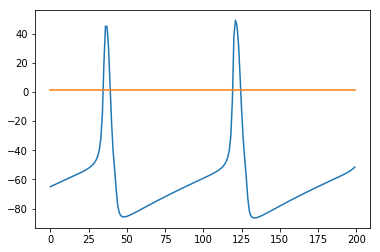

In [10]:
plt.plot(mon.v[0]/mV);
plt.plot(mon.I[0]/nA);

In [11]:
# eqs

In [12]:
new_eqs = get_sensitivity_equations(group, ['gl'])
new_eqs

dS_v_gl/dt = -S_h_gl*g_na*m**3.0*(-ENa + v)/Cm - 3.0*S_m_gl*g_na*h*m**2.0*(-ENa + v)/Cm - 4.0*S_n_gl*g_kd*n**3.0*(-EK + v)/Cm + S_v_gl*(-g_kd*n**4.0 - g_na*h*m**3.0 - gl)/Cm + (El - v)/Cm : metre ** 4 * kilogram ** 2 * second ** -6 * amp ** -3
dS_m_gl/dt = S_m_gl*(-0.32*mV**(-1.0)*(VT + 13.0*mV - v)/(ms*(exp((0.25*VT + 3.25*mV - 0.25*v)/mV) - 1.0)) - 0.28*mV**(-1.0)*(-VT - 40.0*mV + v)/(ms*(exp((-0.2*VT - 8.0*mV + 0.2*v)/mV) - 1.0))) + S_v_gl*(0.056*m*mV**(-2.0)*(exp((-0.2*VT - 8.0*mV + 0.2*v)/mV) - 1.0)**(-2.0)*(-VT - 40.0*mV + v)*exp((-0.2*VT - 8.0*mV + 0.2*v)/mV)/ms - 0.28*m*mV**(-1.0)/(ms*(exp((-0.2*VT - 8.0*mV + 0.2*v)/mV) - 1.0)) + 0.08*mV**(-2.0)*(1.0 - m)*(exp((0.25*VT + 3.25*mV - 0.25*v)/mV) - 1.0)**(-2.0)*(VT + 13.0*mV - v)*exp((0.25*VT + 3.25*mV - 0.25*v)/mV)/ms - 0.32*mV**(-1.0)*(1.0 - m)/(ms*(exp((0.25*VT + 3.25*mV - 0.25*v)/mV) - 1.0))) : ohm
dS_n_gl/dt = S_n_gl*(-0.032*mV**(-1.0)*(VT + 15.0*mV - v)/(ms*(exp((0.2*VT + 3.0*mV - 0.2*v)/mV) - 1.0)) - 0.5*exp((0.025*VT + 0.25

In [13]:
type(new_eqs)

brian2.equations.equations.Equations

#### Get Names of The New Variables

In [15]:
gg = NeuronGroup(1, new_eqs)
diff_eqs = new_eqs.get_substituted_expressions(gg.variables)
diff_eq_names = [name for name, _ in diff_eqs]
diff_eq_names

['S_v_gl', 'S_m_gl', 'S_n_gl', 'S_h_gl']

### Vizualize the Sensitivty Variables

In [16]:
start_scope()

In [17]:
model = eqs + new_eqs

group = NeuronGroup(1, model,
                    method='exponential_euler',
                    namespace={'gl': 5e-5*siemens*cm**-2 * area,})
group.I = '1*nA'
group.v = El
mon = StateMonitor(group, ['v', 'I','S_v_gl', 'S_m_gl', 'S_n_gl', 'S_h_gl'], record=True)

In [18]:
run(20*ms)

In [34]:
output = mon.v

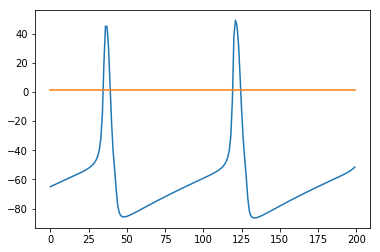

In [35]:
plt.plot(mon.v[0]/mV);
plt.plot(mon.I[0]/nA);

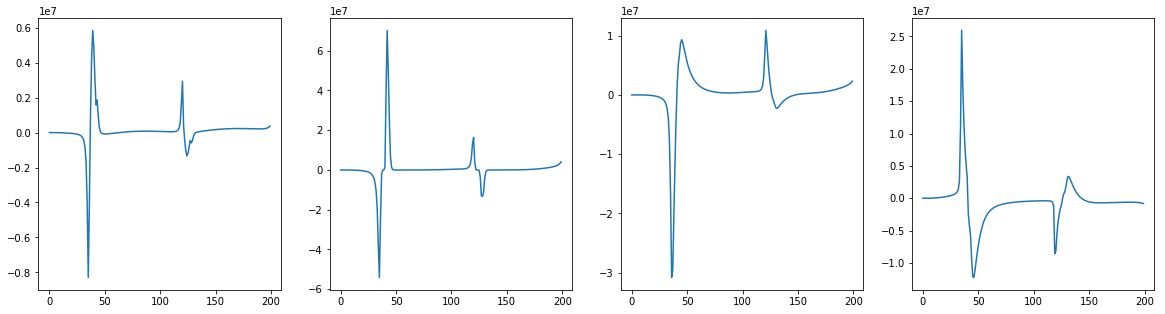

In [36]:
fig, ax = plt.subplots(ncols=4, figsize=(20,5))

ax[0].plot(mon.S_v_gl[0]);
ax[1].plot(mon.S_m_gl[0]);
ax[2].plot(mon.S_n_gl[0]);
ax[3].plot(mon.S_h_gl[0]);

### Create working model to plug into the function

In [59]:
# The model
eqs_fit = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I) / Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I: amp 
gl: siemens(constant)
'''
)

In [60]:
model = eqs_fit + new_eqs
error_unit = output.dim**2
model = model + Equations('total_error : %s' % repr(error_unit))

In [76]:
t_start=0*second
Ntraces, Nsteps = output.shape
duration = Nsteps * dt
output_traces = TimedArray(output.transpose(), dt=dt)
output_var = 'v'
n_samples = 1

In [66]:
start_scope()

In [67]:
neurons = NeuronGroup(1, model,
                    method='exponential_euler',)


neurons.namespace['output_var'] = output_traces
neurons.namespace['Nsteps'] = Nsteps
neurons.namespace['Ntraces'] = Ntraces
neurons.namespace['t_start'] = t_start


neurons.run_regularly('total_error +=  (' + output_var + '-output_var\
                      (t,i % Ntraces))**2 * int(t>=t_start)', when='end')

d = 5e-5*siemens*cm**-2 * area
state = {'gl': d}
neurons.set_states(state)

In [68]:
group.I = '1*nA'
group.v = El
mon = StateMonitor(neurons, ['v', 'I','S_v_gl', 'S_m_gl', 'S_n_gl', 'S_h_gl'], record=True)

In [69]:
run(20*ms)

In [73]:
def calc_error():
    """calculate online error"""
    err = neurons.total_error/int((duration-t_start)/defaultclock.dt)
    err = mean(err.reshape((n_samples, Ntraces)), axis=1)

    return np.array(err)

In [77]:

errors = calc_error()
errors

array([0.00094631])

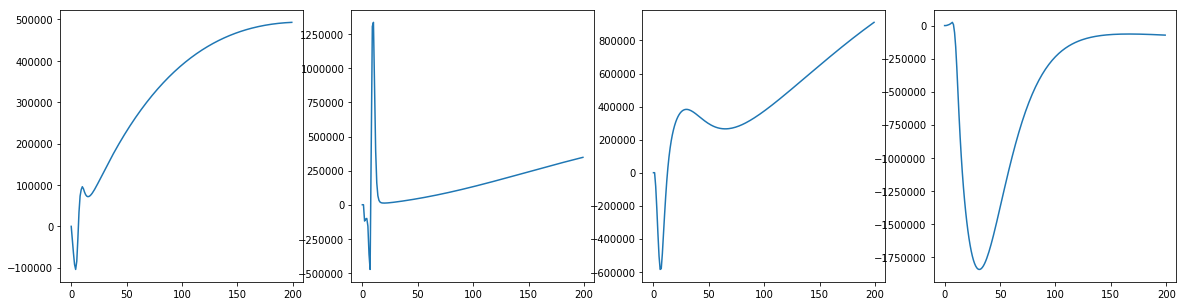

In [78]:
fig, ax = plt.subplots(ncols=4, figsize=(20,5))

ax[0].plot(mon.S_v_gl[0]);
ax[1].plot(mon.S_m_gl[0]);
ax[2].plot(mon.S_n_gl[0]);
ax[3].plot(mon.S_h_gl[0]);